### 项目背景

**用飞桨在放射工作中做点小项目，此项目用PaddleSeg分割肺部和心脏，根据mask计算心胸比。效果如下**

![](https://ai-studio-static-online.cdn.bcebos.com/4fd575d1c7974685bf0814c451dcb3b84634088e0ff749dfb520731030f7ea20)

结合pyqt进行推理
<iframe height="400" width="600"  src="//player.bilibili.com/player.html?aid=798704495&bvid=BV1py4y1m7bP&cid=281982284&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true"> </iframe>


In [1]:
#安装必要库
!pip install paddleseg
!pip install nibabel

In [ ]:
#解压数据
"""
数据来源SIIM气胸数据集和部分网络开源的儿童胸部正位片，挑选101张胸片
进行重新标注
"""

#已经解压了不需要再解压
# %cd /home/aistudio/
# !unzip data/data67397/ChestHeart.zip -d work
# !unzip data/data63611/PaddleSeg-0.8.0.zip -d work

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # This is added back by InteractiveShellApp.init_path()


完成


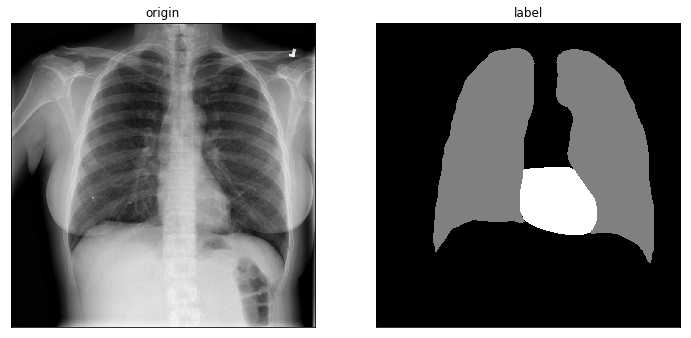

In [ ]:
#因为标签是nii文件，ct值0代表背景，2代表肺部，3代表心脏。
#使用nibabel 转换成jpg格式，原图和标签分开文件夹存放。并生成tain.txt, 和val.txt
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import shutil
def read_nii(nii_path):
    image_data = nib.load(nii_path).get_data()
    #标签从0开始，顺序要连着
    image_data[image_data == 2] =1
    image_data[image_data == 3] =2
    image_data = np.rot90(image_data)
    image_data  = np.flip(image_data ,0)
    return image_data

#展示某种图片和label
image = cv2.imread('/home/aistudio/work/ChestHeart/ID_7c89487be.jpg',0)
label = read_nii('/home/aistudio/work/ChestHeart/ID_7c89487be_jpg_Label.nii.gz')
plt.figure(figsize=(12,6))
plt.subplot(121),plt.imshow(image,'gray'),plt.title('origin'),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(label,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
plt.show

#开始处理label文件, 生成tain.txt, 和val.txt
path_origin = '/home/aistudio/work/ChestHeart/'
train_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/train/'
val_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val/'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.mkdir(os.path.join(train_path,'origin'))
    os.mkdir(os.path.join(train_path,'label'))
if not os.path.exists(val_path):
    os.makedirs(val_path)
    os.mkdir(os.path.join(val_path,'origin'))
    os.mkdir(os.path.join(val_path,'label'))

files = list(filter(lambda x: x.endswith('.jpg') or x.endswith('.jpeg'), os.listdir(path_origin)))
random.shuffle(files)
rate = int(len(files) * 0.8)
train_txt = open('/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/train.txt','w')
val_txt = open('/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val.txt','w')
for i,f in enumerate(files):
    image_path = os.path.join(path_origin, f)
    label_name = f.split('.')[0] + '_' + f.split('.')[1] + '_Label.nii.gz'
    label_data = read_nii(os.path.join(path_origin, label_name))
    if i < rate:
        shutil.copy(image_path, os.path.join(train_path, 'origin', f))  
        cv2.imwrite(os.path.join(train_path, 'label', f),label_data)
        train_txt.write(os.path.join(train_path, 'origin', f) + ' ' + os.path.join(train_path, 'label', f)+ '\n')
    else:
        shutil.copy(image_path, os.path.join(val_path, 'origin', f))
        cv2.imwrite(os.path.join(val_path, 'label', f), label_data)
        val_txt.write(os.path.join(val_path, 'origin', f) + ' ' + os.path.join(val_path, 'label', f)+ '\n')
train_txt.close()
val_txt.close()
print('完成')


### 创建DataSet

In [ ]:
import paddleseg.transforms as T
from paddleseg.datasets import Dataset

train_transforms = [
    T.RandomHorizontalFlip(),
    T.RandomDistort(),
    T.RandomRotation(max_rotation = 10,im_padding_value =(0,0,0),label_padding_value = 0),
    T.RandomBlur(),
    T.RandomScaleAspect(min_scale = 0.8, aspect_ratio = 0.5),
    T.Resize(target_size=(512, 512)),
    T.Normalize()
]
val_transforms = [
    T.Resize(target_size=(512, 512)),
    T.Normalize()
]
dataset_root = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart'
train_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/train.txt'
val_path  = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val.txt'
num_classes = 3
train_dataset = Dataset(transforms = train_transforms,
                  dataset_root = dataset_root,
                  num_classes = num_classes,
                  train_path = train_path,
                  mode = 'train')
val_dataset = Dataset(transforms = val_transforms,
                  dataset_root = dataset_root,
                  num_classes = num_classes,
                  val_path = val_path,
                  mode = 'val')

### 读取DataSet  预览经过数据增强后的数据

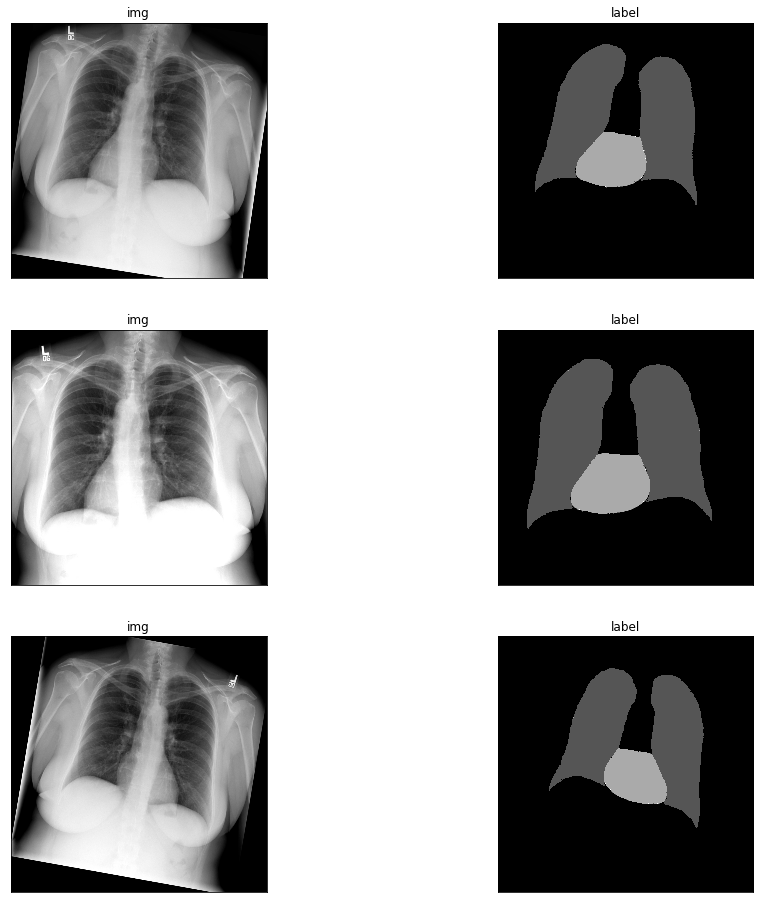

In [ ]:
#没有显示 ，在运行一次
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,16))
for i in range(1,6,2):
    img, label = train_dataset[0]
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.subplot(3,2,i),plt.imshow(img,'gray'),plt.title('img'),plt.xticks([]),plt.yticks([])
    plt.subplot(3,2,i+1),plt.imshow(label,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.show

###  通过paddleSeg导入Unet网络，并设置优化器和loss

In [ ]:
from paddleseg.models import UNet
pretrained = '/home/aistudio/work/model.pdparams'
model = UNet(num_classes=3,pretrained=pretrained)

In [ ]:
from paddleseg.models.losses import CrossEntropyLoss,DiceLoss
import paddle
# 设置学习率
base_lr = 0.0025
lr = paddle.optimizer.lr.PolynomialDecay(base_lr, power=0.9, decay_steps=10000, end_lr=0.000000125)
optimizer = paddle.optimizer.Momentum(lr, parameters=model.parameters(), momentum=0.9, weight_decay=4.0e-5)
# optimizer = paddle.optimizer.Adam(learning_rate=lr,parameters=model.parameters())
#设置loss，比单独使用CrossEntropyLoss， 结合DiceLoss，iou提高了2个点左右
losses = {}
losses['types'] = [CrossEntropyLoss(),DiceLoss()] 
losses['coef'] = [1,1]

In [ ]:
#因为  为了一起使用CrossEntropyLoss  和DiceLoss  稍微改写了 paddleSeg的 train.py
import os
import time
import paddle
import paddle.nn.functional as F
from paddleseg.utils import Timer, calculate_eta, resume, logger
from paddleseg.core.val import evaluate

#改写部分开始
def loss_computation(logits, label, losses):
    loss = 0
    logit =logits[0]
    for i in range(len(losses)):
        if logit.shape[-2:] != label.shape[-2:]:
            logit = F.interpolate(
                logit,
                label.shape[-2:],
                mode='bilinear',
                align_corners=True,
                align_mode=1)
        loss_i = losses['types'][i](logit, label)
        loss += losses['coef'][i] * loss_i
    return loss
#改写部分结束

def train(model,
          train_dataset,
          val_dataset=None,
          optimizer=None,
          save_dir='output',
          iters=10000,
          batch_size=2,
          resume_model=None,
          save_interval=1000,
          log_iters=10,
          num_workers=0,
          use_vdl=False,
          losses=None):
    nranks = paddle.distributed.ParallelEnv().nranks
    local_rank = paddle.distributed.ParallelEnv().local_rank
    start_iter = 0
    if resume_model is not None:
        start_iter = resume(model, optimizer, resume_model)

    if not os.path.isdir(save_dir):
        if os.path.exists(save_dir):
            os.remove(save_dir)
        os.makedirs(save_dir)

    batch_sampler = paddle.io.DistributedBatchSampler(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    loader = paddle.io.DataLoader(
        train_dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        return_list=True,
    )

    if use_vdl:
        from visualdl import LogWriter
        if not os.path.exists(os.path.join(save_dir,'log')):
            os.mkdir(os.path.join(save_dir,'log'))
        log_writer = LogWriter(os.path.join(save_dir,'log'))

    timer = Timer()
    avg_loss = 0.0
    iters_per_epoch = len(batch_sampler)
    best_mean_iou = -1.0
    best_model_iter = -1
    train_reader_cost = 0.0
    train_batch_cost = 0.0
    timer.start()

    iter = start_iter
    while iter < iters:
        for data in loader:
            iter += 1
            if iter > iters:
                break
            train_reader_cost += timer.elapsed_time()
            images = data[0]
            labels = data[1].astype('int64')
            logits = model(images)
            loss = loss_computation(logits, labels, losses)
            loss.backward()
            optimizer.step()
            lr = optimizer.get_lr()
            if isinstance(optimizer._learning_rate,
                          paddle.optimizer.lr.LRScheduler):
                optimizer._learning_rate.step()
            model.clear_gradients()
            avg_loss += loss.numpy()[0]
            train_batch_cost += timer.elapsed_time()
            if (iter) % log_iters == 0 and local_rank == 0:
                avg_loss /= log_iters
                avg_train_reader_cost = train_reader_cost / log_iters
                avg_train_batch_cost = train_batch_cost / log_iters
                train_reader_cost = 0.0
                train_batch_cost = 0.0
                remain_iters = iters - iter
                eta = calculate_eta(remain_iters, avg_train_batch_cost)
                logger.info(
                    "[TRAIN] epoch={}, iter={}/{}, loss={:.4f}, lr={:.6f}, batch_cost={:.4f}, reader_cost={:.4f} | ETA {}"
                    .format((iter - 1) // iters_per_epoch + 1, iter, iters,
                            avg_loss, lr, avg_train_batch_cost,
                            avg_train_reader_cost, eta))
                if use_vdl:
                    log_writer.add_scalar('Train/loss', avg_loss, iter)
                    log_writer.add_scalar('Train/lr', lr, iter)
                    log_writer.add_scalar('Train/batch_cost',
                                          avg_train_batch_cost, iter)
                    log_writer.add_scalar('Train/reader_cost',
                                          avg_train_reader_cost, iter)
                avg_loss = 0.0

            if (iter % save_interval == 0
                    or iter == iters) and (val_dataset is not None):
                num_workers = 1 if num_workers > 0 else 0
                mean_iou, acc = evaluate(
                    model, val_dataset, num_workers=num_workers)
                model.train()

            if (iter % save_interval == 0 or iter == iters) and local_rank == 0:
                current_save_dir = os.path.join(save_dir,
                                                "iter_{}".format(iter))
                if not os.path.isdir(current_save_dir):
                    os.makedirs(current_save_dir)
                paddle.save(model.state_dict(),
                            os.path.join(current_save_dir, 'model.pdparams'))
                paddle.save(optimizer.state_dict(),
                            os.path.join(current_save_dir, 'model.pdopt'))

                if val_dataset is not None:
                    if mean_iou > best_mean_iou:
                        best_mean_iou = mean_iou
                        best_model_iter = iter
                        best_model_dir = os.path.join(save_dir, "best_model")
                        paddle.save(
                            model.state_dict(),
                            os.path.join(best_model_dir, 'model.pdparams'))
                    logger.info(
                        '[EVAL] The model with the best validation mIoU ({:.4f}) was saved at iter {}.'
                        .format(best_mean_iou, best_model_iter))

                    if use_vdl:
                        log_writer.add_scalar('Evaluate/mIoU', mean_iou, iter)
                        log_writer.add_scalar('Evaluate/Acc', acc, iter)
            timer.restart()

    time.sleep(0.5)
    if use_vdl:
        log_writer.close()


### 训练开始

In [ ]:

train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output',
    iters=3000,
    batch_size=4,
    save_interval=200,
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)

通过VisualDL观察训练结果的变化

![](https://ai-studio-static-online.cdn.bcebos.com/d7d4bb692f8342cb95e2c86ad19a58ccb2f81d80e8cc44f6afe18c5550744463)


### 评估
iou分别是 [0.9791 0.9569 0.9173]

In [ ]:
from paddleseg.models import UNet
from paddleseg.core import evaluate
model = UNet(num_classes=3)
#这是我训练保存模型，记得换回自己训练模型的地址，训练期间默认保存地址如下
#/home/aistudio/output/best_model/model.pdparams
model_path = '/home/aistudio/work/best_model.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
evaluate(model,val_dataset)

2021-01-09 11:40:35 [INFO]	Start evaluating (total_samples=21, total_iters=21)...


 3/21 [===>..........................] - ETA: 0s - batch_cost: 0.0183 - reader cost: 0.0042        21/21 [==============================] - 1s 34ms/step - batch_cost: 0.0316 - reader cost: 0.013


2021-01-09 11:40:35 [INFO]	[EVAL] #Images=21 mIoU=0.9511 Acc=0.9839 Kappa=0.9669 
2021-01-09 11:40:35 [INFO]	[EVAL] Class IoU: 
[0.9791 0.9569 0.9173]
2021-01-09 11:40:35 [INFO]	[EVAL] Class Acc: 
[0.9892 0.9789 0.9558]


(0.9510999, 0.9839292)

### 预测并显示结果

In [21]:
import os
import paddleseg.transforms as T
from paddleseg.core import predict
from paddleseg.models import UNet
transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
])

model = UNet(num_classes=3)
#生成图片列表
image_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val/origin' 
image_list = []
for root, dirs, files in os.walk(image_path):
    for f in files:
        image_list.append(os.path.join(root, f))
predict(
        model,
        #这是我训练的模型
        model_path='/home/aistudio/work/best_model.pdparams',
        transforms=transforms,
        image_list=image_list,
        save_dir='output/results',
    )

2021-01-11 10:40:00 [INFO]	Start to predict...


 1/39 [..............................] - ETA: 3s39/39 [==============================] - 4s 98ms/ste


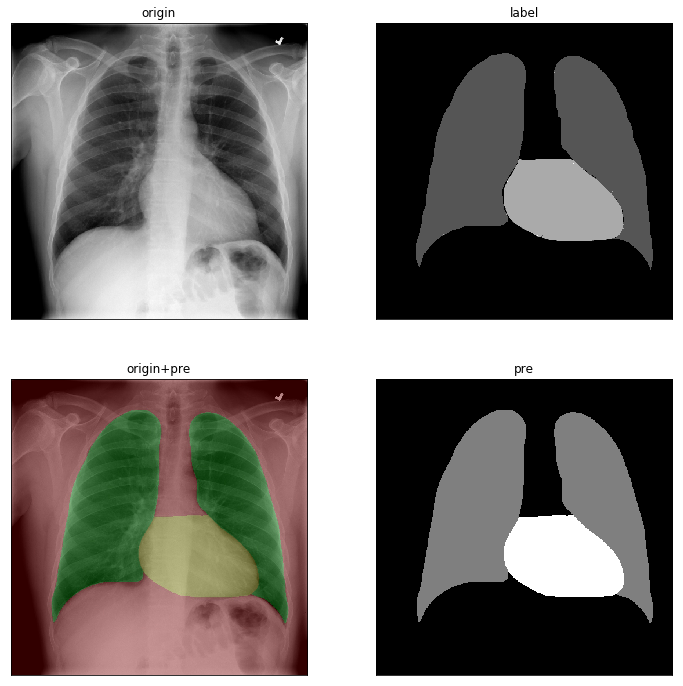

In [24]:
from paddleseg.models import UNet
import cv2
import paddleseg.transforms as T
import paddle
import numpy as np
import matplotlib.pyplot as plt

transforms = T.Compose([
    # T.Resize(target_size=(512, 512)),
    T.ResizeByLong(512),
    T.Normalize()
])

def predict(model, model_path, im_path):
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    model.eval()
    im = cv2.imread(im_path)
    im, _ = transforms(im)
    im = im[np.newaxis, ...]
    im = paddle.to_tensor(im)
    output = model(im)[0]
    output = output.numpy()
    output = np.argmax(output,axis=1)
    output = output.transpose(1,2,0)
    return output

im_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val/origin/ID_854e17350.jpg'
vis_path = 'output/results/added_prediction/ID_854e17350.jpg'
label_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val/label/ID_854e17350.jpg'
model = UNet(num_classes=3)
model_path = '/home/aistudio/work/best_model.pdparams'

output = predict(model, model_path, im_path)
w,h = output.shape[0], output.shape[1]
segmentation = np.zeros((w,h,1))#用来保存分割结果

image = cv2.imread(im_path)
image, _ = transforms(image)
image = image*0.5 + 0.5
image = np.transpose(image,(1,2,0))

label = cv2.imread(label_path,0)

for i in np.arange(w):
    for j in np.arange(h):
        if output[i,j,0] == 1:
            output[i,j,0] = 127
        elif output[i,j,0] == 2:
            output[i,j,0] = 255
segmentation[:, :, 0] = output[:,:,0] # 保存分割结果
plt.figure(figsize=(12, 12))
segmentation = np.squeeze(segmentation)
# cv2.imwrite('b.jpg',segmentation)
plt.subplot(2,2,1),plt.imshow(image,'gray'), plt.title('origin'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,2),plt.imshow(label,'gray'), plt.title('label'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,3),plt.imshow(cv2.imread(vis_path)), plt.title('origin+pre'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,4),plt.imshow(segmentation,'gray'), plt.title('pre'),plt.xticks([]),plt.yticks([])
plt.show()

### 心胸比简单介绍

**心胸比指：在X线上心脏横径(左右心缘至体中线的最大距离之和)与胸廓横径(通过右膈顶水平胸廓内径，也有学者认为右膈经常形态常有变异，通过右膈顶的测量值未必准确)的比例**

**是确定心脏有无增大的最简便的方法。**

**正常值女性约为0.45，男性约为0.43，小于0.5即被认为正常，而大于0.5则被认为有心脏扩大。0.51-0.55为轻度扩大，0.56-0.60为中度扩大，而大于0.6则为重度扩大。**

**需要临床医生手动量取三次距离，在通过计算才能得出心胸比。**

**注意：对计算心胸比的胸片也有一定要求的。例如患者做好是站立后前位拍摄胸片，心脏投影失真比例少，并拍摄时是深吸气拍摄。在肺野中最好可以看到7到8肋，左心室的最左侧可以显示更多。这样胸片测量心胸比的效果才比较好。还有幼儿因为不能站立拍摄胸片（卧位），和不能配合深吸气拍摄。所有幼儿的胸片测量出来的心胸比一般都比正常情况的要大**

![](https://ai-studio-static-online.cdn.bcebos.com/12f713677ff442ea82247154830c3dfcc9b6efd911ee4b149dc5e4b2d46ce296)



**计算机方法：现在通过分割肺部和心脏部分，根据Mask图，得到肺部和心脏的边界矩形。得到对应的width，就可以自动求得心胸比**

![](https://ai-studio-static-online.cdn.bcebos.com/d5ee5a1443b34f009fc2917b1036f2f851d48b1e38bf49bf98b129a9df4cacab)


### 计算心胸比

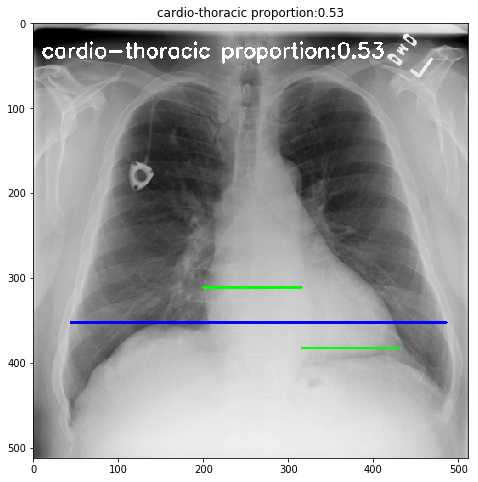

True

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from paddleseg.models import UNet
import cv2
import paddleseg.transforms as T
import paddle
import numpy as np
import matplotlib.pyplot as plt
import time

transforms = T.Compose([
    T.ResizeByLong(512),
    T.Normalize()
])

def predict(model, model_path, im_path):
    #预测
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    model.eval()
    im = cv2.imread(im_path)
    im, _ = transforms(im)
    im = im[np.newaxis, ...]
    im = paddle.to_tensor(im)
    output = model(im)[0]
    output = output.numpy()
    output = np.argmax(output,axis=1)
    output = output.transpose(1,2,0)
    return output

def find_max_area(contours):
    # 找到最大的轮廓
    area = []
    for k in range(len(contours)):
        area.append(cv2.contourArea(contours[k]))
    max_idx = np.argmax(np.array(area))
    return max_idx

def morph_open(threshold):
    #开运算去除噪声
    kernel = np.ones((3,3), np.uint8)
    threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN,kernel, iterations=3)
    return threshold

def get_left_right(cnt):
    #计算最左  和最后的点, 外边距的x,y,w,h
    left = tuple(cnt[cnt[:,:,0].argmin()][0])
    right = tuple(cnt[cnt[:,:,0].argmax()][0])
    x,y,w,h = cv2.boundingRect(cnt)
    return (left, right,x,y,w,h)


def calc_diaphragm(image,hy, cx,cw,step):
    #为了找出右膈肌顶的位置
    #这种方法比较粗糙（希望有更好的方法请告诉我！！），通过大致找到右肺，和根据心脏的左侧，圈出一小块
    #循环往下走，计算出现黑色像素就暂时，这个位置就右侧膈肌顶
    im = image.copy()
    width = int(cw/8)
    while True:
        im = image[hy:hy+step,cx+width:cx+width*2]
        no_black_pixels = cv2.countNonZero(im)
        if no_black_pixels < int(width * step*0.95):
            return hy+step
        hy = hy + step

# im_path = '/home/aistudio/work/PaddleSeg-0.8.0/dataset/chestHeart/val/origin/ID_854e17350.jpg'
im_path = '/home/aistudio/work/newTest/ID_ffb1eed56.jpg'
model = UNet(num_classes=3)
model_path = '/home/aistudio/work/best_model.pdparams'

output = predict(model, model_path, im_path)

w,h = output.shape[0], output.shape[1]
segmentation = np.zeros((w,h,1),np.uint8)#用来保存分割结果

#用来展示画图用
image = cv2.imread(im_path)
resizeLong = T.ResizeByLong(512)
image= resizeLong(image)[0]

segmentation[:, :, 0] = output[:,:,0] # 保存分割结果
segmentation = np.squeeze(segmentation)

#找出心脏位置
ret, heart = cv2.threshold(segmentation, 1, 255,0)
heart = morph_open(heart)
contours, hierarchy = cv2.findContours(heart, 1,2)
max_idx = find_max_area(contours)
heart = contours[max_idx]
#得到心脏的最左的点和最右的点，和边界矩形的x，y，width,height
left_heart, right_heart ,hx,hy,WidthHeart,hh= get_left_right(heart)

#这次是找出肺部位置
img_temp = segmentation.copy()
w,h = img_temp.shape[0], img_temp.shape[1]
#把心脏和肺部当做一个整体，方便计算边界矩形
ret, chest = cv2.threshold(img_temp, 0, 255,0)
chest = morph_open(chest)
contours, hierarchy = cv2.findContours(chest, 1,2)
max_idx = find_max_area(contours)
chest = contours[max_idx]
#得到肺部的最左的点和最右的点，和外边距的x，y，width,height
left_chest, right_chest,cx,cy,WidthChest,ch = get_left_right(chest)

#根据上面找到肺的最左位置和width传入找膈肌顶的函数中，
#缩小肺的范围，再找一次肺的最左的点和最右的点，和外边距的x，y，width,height
position_y = calc_diaphragm(img_temp,left_heart[1],left_chest[0],WidthChest,5)
ret, chest = cv2.threshold(img_temp[:position_y,:], 0, 255,0)
chest = morph_open(chest)
contours, hierarchy = cv2.findContours(chest, 1,2)
max_idx = find_max_area(contours)
chest = contours[max_idx]
#得到第二次肺部的最左的点和最右的点，和外边距的x，y，width,height
left_chest, right_chest,cx,cy,WidthChest,ch = get_left_right(chest)

#画出肺部的最大横径 和心脏的横径
cv2.line(image,left_heart,(left_heart[0] + int(WidthHeart/2),left_heart[1]),(0,255,0),2)
cv2.line(image,right_heart,(right_heart[0] - int(WidthHeart/2),right_heart[1]),(0,255,0),2)
cv2.line(image,left_chest,(left_chest[0] + WidthChest,left_chest[1]),(0,0,255),2)
font = cv2.FONT_HERSHEY_SIMPLEX  # 定义字体
#计算心胸比
cv2.putText(image, 'cardio-thoracic proportion:{}'.format(round(WidthHeart/WidthChest,2)), (10, 40), font, 0.8, (255, 255, 255), 2)
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title("cardio-thoracic proportion:{}".format(round(WidthHeart/WidthChest,2)))
plt.show()
result_path = im_path.split('.')[0] + '_result.jpg'
cv2.imwrite(result_path,image)

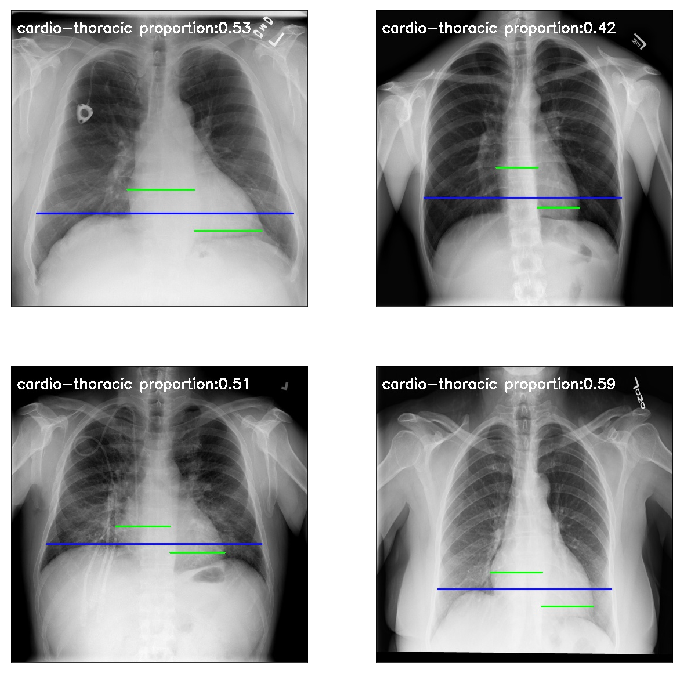

In [10]:
#展示部分效果
import matplotlib.pyplot as plt 
import os
image_path = '/home/aistudio/work/newTest'
images = list(filter(lambda x: 'result' in x, os.listdir(image_path) ))
plt.figure(figsize=(12,12))
for i in range(len(images)):
    im = cv2.imread(os.path.join(image_path, images[i]))
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)
plt.show()

### 个人介绍

广州某医院的放射科的一名放射技师。

只是一位编程爱好者

只是想把自己的爱好融入工作中

只是想让自己通过努力获取成就和快乐

欢迎更多志同道合的朋友一起玩耍~~~

我在AI Studio上获得钻石等级，点亮9个徽章，来互关呀~ [https://aistudio.baidu.com/aistudio/personalcenter/thirdview/181096](http://)